In [245]:
import pandas as pd
import os
import os.path as op
import arviz as az
from bauer.models import PsychometricModel

from tms_risk.utils.data import get_all_behavior
from tms_risk.cogmodels.fit_probit import build_model, get_data
import numpy as np
import pingouin as pg
from tms_risk.cogmodels.utils import extract_intercept_gamma, format_bambi_ppc, plot_ppc
from IPython.display import display

bids_folder = '/data/ds-tmsrisk'

# Simple probit MAP

In [243]:
df = get_all_behavior(bids_folder=bids_folder, all_tms_conditions=True, exclude_outliers=True)
df = df.drop('baseline', level='stimulation_condition')
map_pars = pd.read_csv(op.join(bids_folder, 'derivatives', 'map_models', 'psychometric_simple.csv'), index_col=['subject', 'stimulation_condition'])
map_pars['gamma'] = 1./(2*np.sqrt(map_pars['nu']))
map_pars['rnp'] = np.exp(map_pars['bias'])

idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', 'model-probit_simple_trace.netcdf'))
data = get_data('probit_simple', bids_folder)
model = build_model('probit_simple', data)
intercept, gamma = extract_intercept_gamma(idata, model, data, group=False)
intercept = intercept.stack([1, 2], future_stack=True)['intercept']
gamma = gamma.stack([1, 2], future_stack=True)['gamma']

rnp = np.exp(intercept/gamma).rename('rnp')
bayesian_pars = rnp.groupby(['subject', 'stimulation_condition']).mean().to_frame().join(gamma.groupby(['subject', 'stimulation_condition']).mean())


Dropping the baseline condition


In [300]:
map_pars['gamma'] = 1./(np.sqrt(2)*map_pars['nu'])

map_pars['distance_to_risk_neutrality'] = np.abs(map_pars['rnp'] - 0.55)
bayesian_pars['distance_to_risk_neutrality'] = np.abs(bayesian_pars['rnp'] - 0.55)

,,n,r,CI95%,p-val,BF10,power
stimulation_condition,,,,,,,
ips,pearson,35,0.948699,"[0.9, 0.97]",4.558051e-18,7.543e+14,1.0
vertex,pearson,35,0.972506,"[0.95, 0.99]",1.844819e-22,9.947e+18,1.0


,,n,r,CI95%,p-val,BF10,power
stimulation_condition,,,,,,,
ips,pearson,35,0.784367,"[0.61, 0.89]",2.472957e-08,6.124e+05,0.999977
vertex,pearson,35,0.890462,"[0.79, 0.94]",7.994065e-13,9.303e+09,1.000000


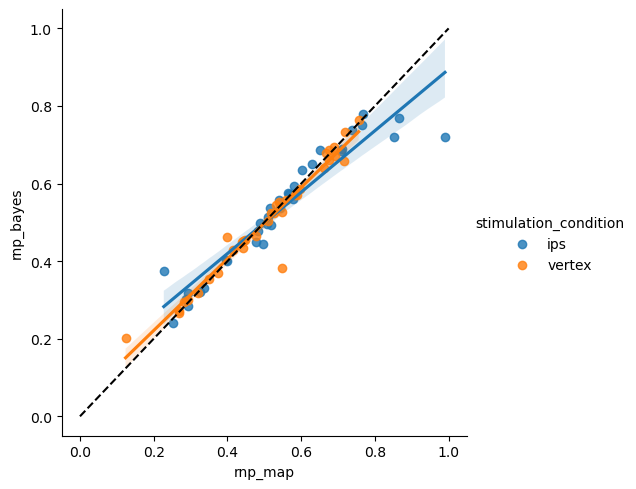

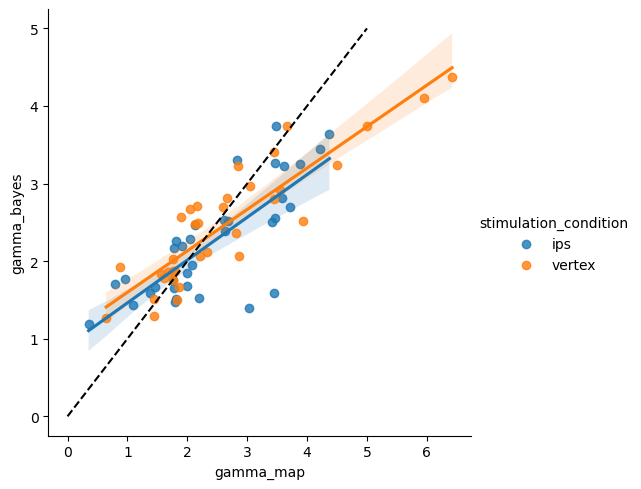

In [314]:
pars = map_pars.join(bayesian_pars, lsuffix='_map', rsuffix='_bayes')

sns.lmplot(data=pars.reset_index(), x='rnp_map', y='rnp_bayes', hue='stimulation_condition', fit_reg=True)
plt.plot([0, 1], [0, 1], 'k--')

sns.lmplot(data=pars.reset_index(), x='gamma_map', y='gamma_bayes', hue='stimulation_condition', fit_reg=True)
plt.plot([0, 5], [0, 5], 'k--')

display(pars.groupby('stimulation_condition').apply(lambda x: pg.corr(x['rnp_map'], x['rnp_bayes'])))
display(pars.groupby('stimulation_condition').apply(lambda x: pg.corr(x['gamma_map'], x['gamma_bayes'])))




,,n,r,CI95%,p-val,BF10,power
stimulation_condition,,,,,,,
ips,pearson,35,0.859105,"[0.74, 0.93]",3.993255e-11,2.416e+08,1.0
vertex,pearson,35,0.929128,"[0.86, 0.96]",8.140348e-16,5.858e+12,1.0


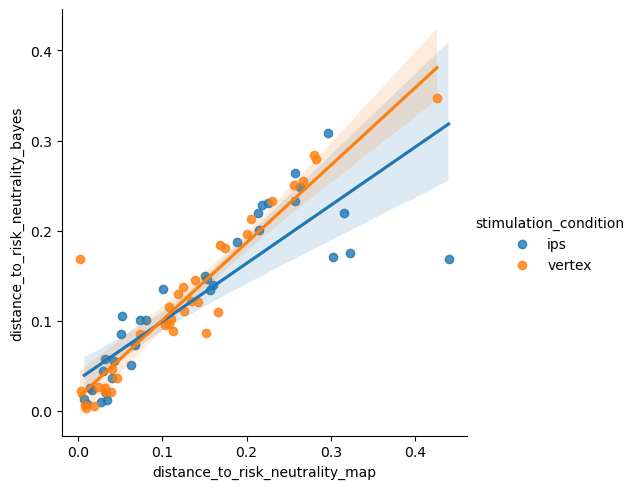

In [325]:
sns.lmplot(data=pars.reset_index(), x='distance_to_risk_neutrality_map', y='distance_to_risk_neutrality_bayes', hue='stimulation_condition', fit_reg=True)

display(pars.groupby('stimulation_condition').apply(lambda x: pg.corr(x['distance_to_risk_neutrality_map'], x['distance_to_risk_neutrality_bayes'])))

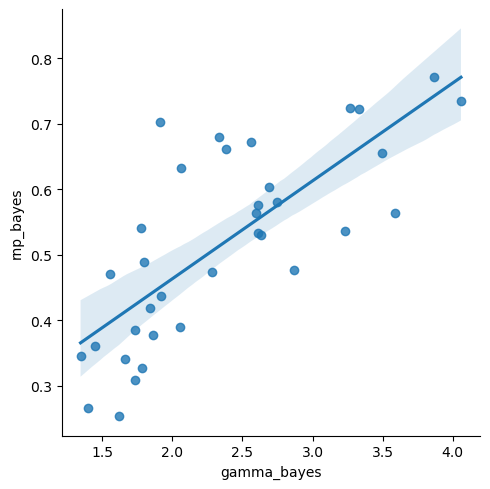

In [329]:
sns.lmplot(data=pars.groupby('subject').mean().reset_index(), x='gamma_bayes', y='rnp_bayes', fit_reg=True)

In [335]:
display(pg.corr(pars.groupby('subject').mean()['gamma_bayes'], pars.groupby('subject').mean()['rnp_bayes']))
display(pg.corr(pars.groupby('subject').mean()['gamma_map'], pars.groupby('subject').mean()['rnp_map']))
display(pg.corr(pars.groupby('subject').mean()['gamma_bayes'], pars.groupby('subject').mean()['distance_to_risk_neutrality_bayes']))
display(pg.corr(pars.groupby('subject').mean()['gamma_map'], pars.groupby('subject').mean()['distance_to_risk_neutrality_map']))

,n,r,CI95%,p-val,BF10,power
pearson,35,0.756129,"[0.57, 0.87]",1.497074e-07,1.157e+05,0.999885


,n,r,CI95%,p-val,BF10,power
pearson,35,0.456227,"[0.15, 0.69]",0.005876,8.038,0.805212


,n,r,CI95%,p-val,BF10,power
pearson,35,-0.3037,"[-0.58, 0.03]",0.076126,0.953,0.434724


,n,r,CI95%,p-val,BF10,power
pearson,35,-0.259858,"[-0.55, 0.08]",0.131672,0.627,0.331051


In [333]:
display(pg.corr(pars.groupby('subject').mean()['gamma_map'], pars.groupby('subject').mean()['distance_to_risk_neutrality_map']))

,n,r,CI95%,p-val,BF10,power
pearson,35,-0.259858,"[-0.55, 0.08]",0.131672,0.627,0.331051


,n,r,CI95%,p-val,BF10,power
pearson,35,0.781618,"[0.61, 0.88]",2.980837e-08,5.151e+05,0.999973


,n,r,CI95%,p-val,BF10,power
pearson,35,0.406677,"[0.08, 0.65]",0.015335,3.538,0.69557


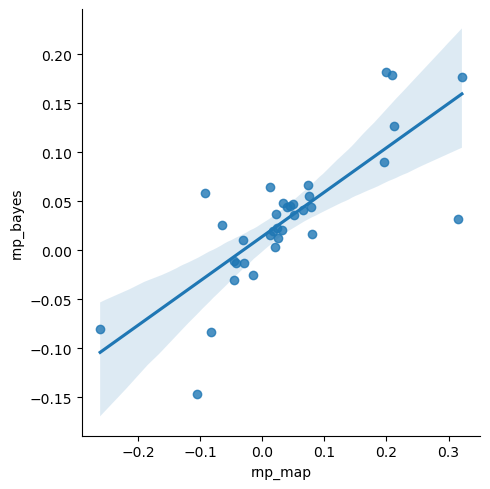

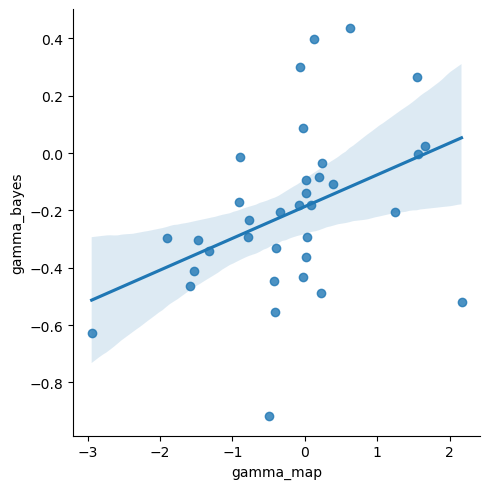

In [316]:
diff = pars.unstack('stimulation_condition').swaplevel(axis=1)

diff = diff['ips'] - diff['vertex']

sns.lmplot(data=diff.reset_index(), x='rnp_map', y='rnp_bayes', fit_reg=True)
sns.lmplot(data=diff.reset_index(), x='gamma_map', y='gamma_bayes', fit_reg=True)

display(pg.corr(diff['rnp_map'], diff['rnp_bayes']))
display(pg.corr(diff['gamma_map'], diff['gamma_bayes']))

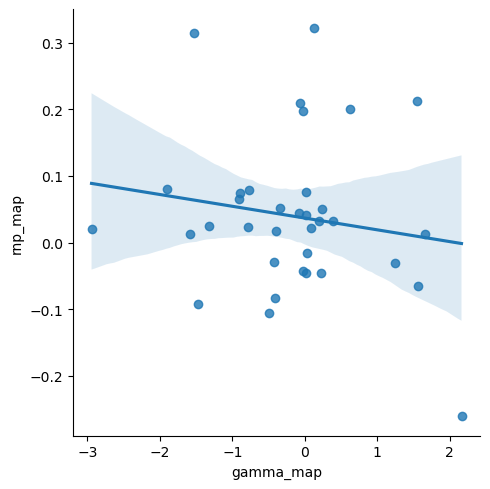

In [317]:
sns.lmplot(data=diff, x='gamma_map', y='rnp_map', fit_reg=True)

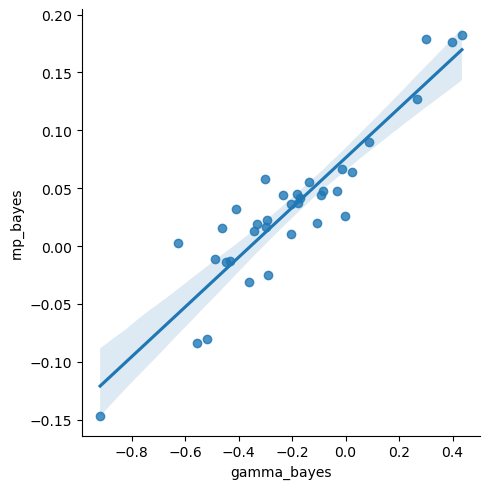

In [318]:
sns.lmplot(data=diff, x='gamma_bayes', y='rnp_bayes', fit_reg=True)

,n,r,CI95%,p-val,BF10,power
pearson,35,-0.422474,"[-0.66, -0.1]",0.011464,4.529,0.732675


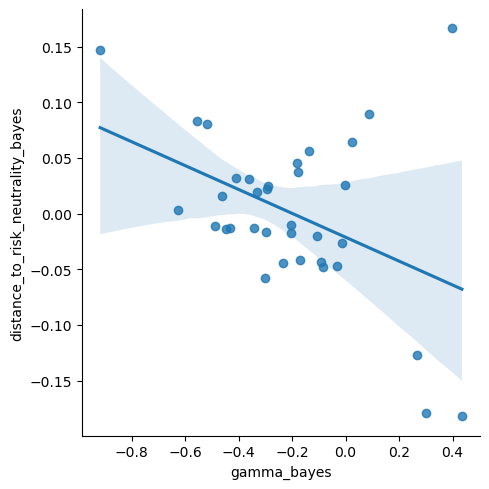

In [322]:
sns.lmplot(data=diff, x='gamma_bayes', y='distance_to_risk_neutrality_bayes', fit_reg=True)

pg.corr(diff['gamma_bayes'], diff['distance_to_risk_neutrality_bayes'])

,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,stimulation_condition,1,34,4.088561,0.0511,0.013954,1.0


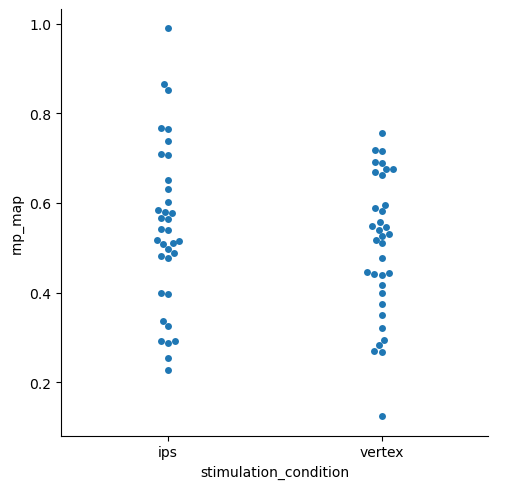

In [288]:
sns.catplot(x='stimulation_condition', y='rnp_map', data=pars.reset_index(), kind='swarm')

pg.rm_anova(pars.reset_index(), dv='rnp_map', within='stimulation_condition', subject='subject')

# Order probit model

In [373]:
df = get_all_behavior(bids_folder=bids_folder, all_tms_conditions=True, exclude_outliers=True)
df = df.drop('baseline', level='stimulation_condition')
map_pars = pd.read_csv(op.join(bids_folder, 'derivatives', 'map_models', 'psychometric_order.csv'), index_col=['subject', 'stimulation_condition', 'risky_first'])
map_pars['gamma'] = 1./(2*np.sqrt(map_pars['nu']))
map_pars['rnp'] = np.exp(map_pars['bias'])

idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', 'model-probit_order_trace.netcdf'))
data = get_data('probit_order', bids_folder)
model = build_model('probit_order', data)
intercept, gamma = extract_intercept_gamma(idata, model, data, group=False)
intercept = intercept.stack([1, 2], future_stack=True)['intercept']
gamma = gamma.stack([1, 2], future_stack=True)['gamma']

bayesian_pars = intercept.groupby(['subject', 'stimulation_condition', 'risky_first']).mean().to_frame().join(gamma.groupby(['subject', 'stimulation_condition']).mean())
bayesian_pars['rnp'] = np.exp(bayesian_pars['intercept']/bayesian_pars['gamma']).rename('rnp')

Dropping the baseline condition


In [374]:
map_pars['gamma'] = 1./(np.sqrt(2)*map_pars['nu'])


# Set any RNPs outside of 0.0 and 1.0 to nan
map_pars.loc[map_pars['rnp'] < 0, 'rnp'] = np.nan
map_pars.loc[map_pars['rnp'] > 1, 'rnp'] = np.nan

bayesian_pars.loc[bayesian_pars['rnp'] < 0, 'rnp'] = np.nan
bayesian_pars.loc[bayesian_pars['rnp'] > 1, 'rnp'] = np.nan

map_pars['distance_to_risk_neutrality'] = np.abs(map_pars['rnp'] - 0.55)
bayesian_pars['distance_to_risk_neutrality'] = np.abs(bayesian_pars['rnp'] - 0.55)

n         r         CI95%  \
stimulation_condition risky_first                                       
ips                   False       pearson  32  0.955764  [0.91, 0.98]   
                      True        pearson  34  0.956849  [0.91, 0.98]   
vertex                False       pearson  35  0.853650  [0.73, 0.92]   
                      True        pearson  35  0.884928  [0.78, 0.94]   

                                                  p-val       BF10  power  
stimulation_condition risky_first                                          
ips                   False       pearson  1.716043e-17  1.913e+14    1.0  
                      True        pearson  9.745379e-19  3.063e+15    1.0  
vertex                False       pearson  7.162479e-11  1.402e+08    1.0  
                      True        pearson  1.727698e-12  4.529e+09    1.0

n         r         CI95%  \
stimulation_condition risky_first                                       
ips                   False       pearson  35  0.658039  [0.42, 0.81]   
                      True        pearson  35  0.553723  [0.27, 0.75]   
vertex                False       pearson  35  0.804122   [0.64, 0.9]   
                      True        pearson  35  0.637592   [0.39, 0.8]   

                                                  p-val     BF10     power  
stimulation_condition risky_first                                           
ips                   False       pearson  1.738036e-05  1467.24  0.994709  
                      True        pearson  5.591728e-04   63.749  0.946374  
vertex                False       pearson  5.938387e-09  2.3e+06  0.999994  
                      True        pearson  3.796684e-05  720.402  0.990742

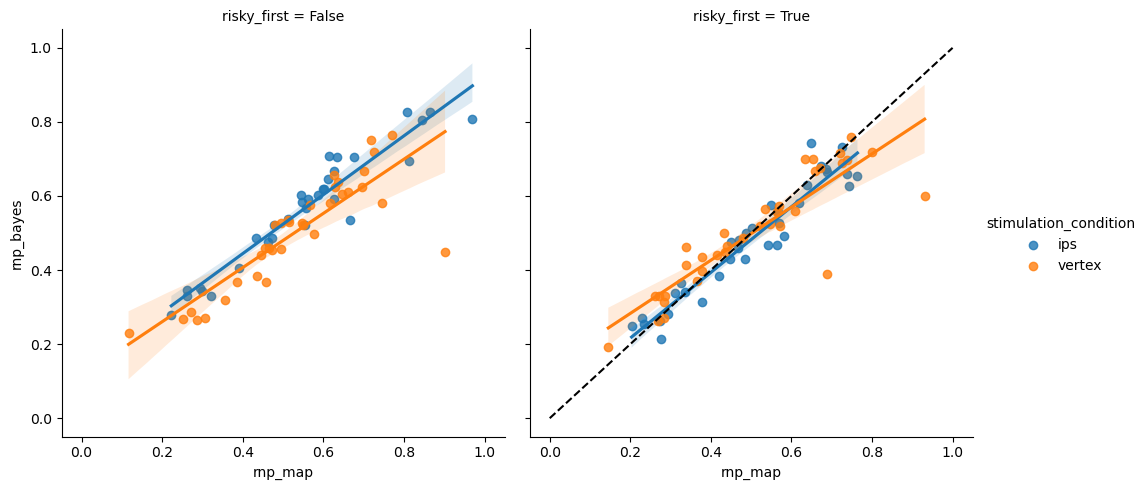

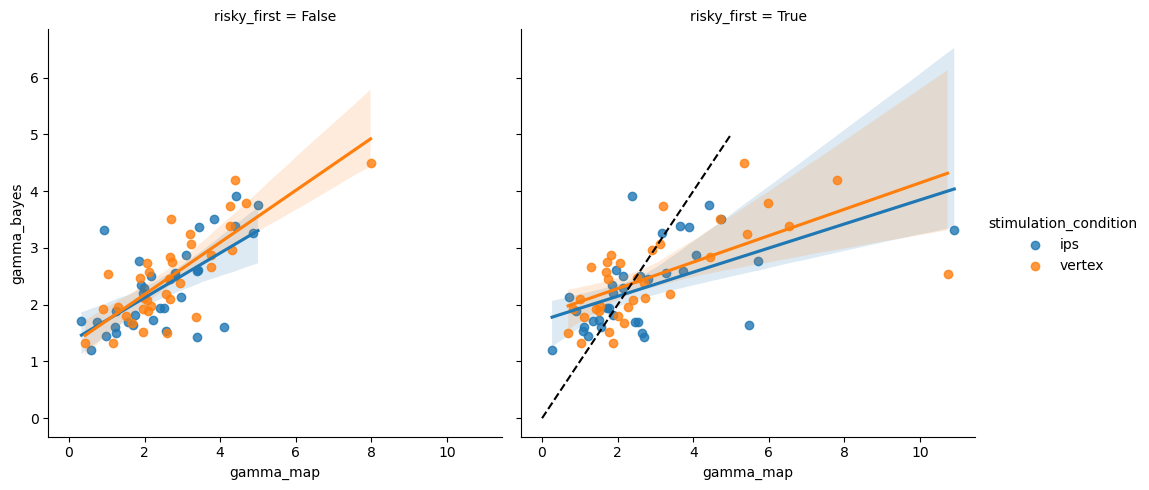

In [375]:
pars = map_pars.join(bayesian_pars, lsuffix='_map', rsuffix='_bayes')

sns.lmplot(data=pars.reset_index(), x='rnp_map', y='rnp_bayes', hue='stimulation_condition', fit_reg=True, col='risky_first')
plt.plot([0, 1], [0, 1], 'k--')

sns.lmplot(data=pars.reset_index(), x='gamma_map', y='gamma_bayes', hue='stimulation_condition', fit_reg=True, col='risky_first')
plt.plot([0, 5], [0, 5], 'k--')

display(pars.groupby(['stimulation_condition', 'risky_first']).apply(lambda x: pg.corr(x['rnp_map'], x['rnp_bayes'])))
display(pars.groupby(['stimulation_condition', 'risky_first']).apply(lambda x: pg.corr(x['gamma_map'], x['gamma_bayes'])))

n         r         CI95%  \
stimulation_condition risky_first                                       
ips                   False       pearson  32  0.892209  [0.79, 0.95]   
                      True        pearson  34  0.879915  [0.77, 0.94]   
vertex                False       pearson  35  0.797081  [0.63, 0.89]   
                      True        pearson  35  0.778384   [0.6, 0.88]   

                                                  p-val       BF10     power  
stimulation_condition risky_first                                             
ips                   False       pearson  7.065260e-12  1.145e+09  1.000000  
                      True        pearson  7.176519e-12  1.177e+09  1.000000  
vertex                False       pearson  1.005101e-08  1.411e+06  0.999990  
                      True        pearson  3.700830e-08  4.216e+05  0.999967

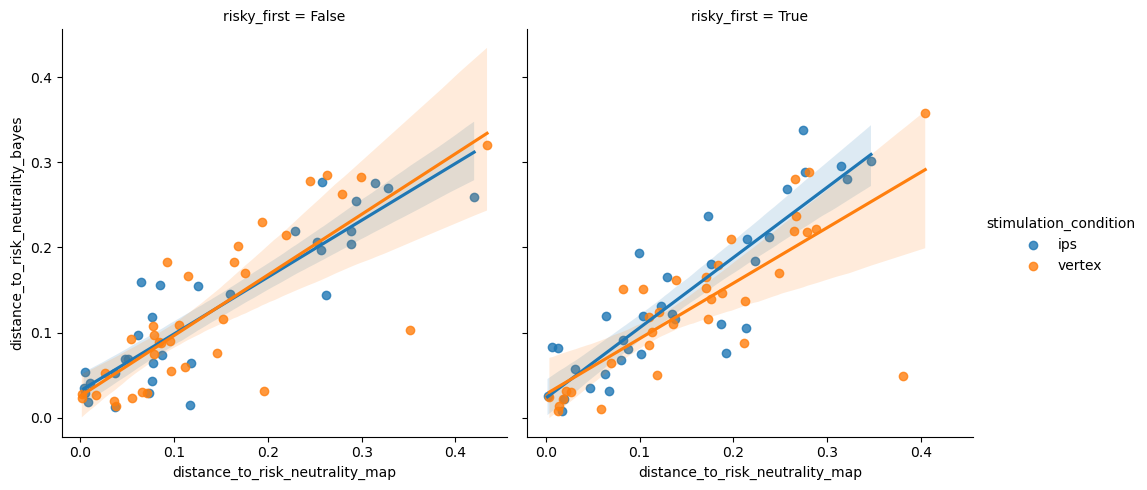

In [376]:
sns.lmplot(data=pars.reset_index(), x='distance_to_risk_neutrality_map', y='distance_to_risk_neutrality_bayes', hue='stimulation_condition', fit_reg=True, col='risky_first')

display(pars.groupby(['stimulation_condition', 'risky_first']).apply(lambda x: pg.corr(x['distance_to_risk_neutrality_map'], x['distance_to_risk_neutrality_bayes'])))

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_33300/312331818.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  display(subjectwise_pars.groupby('risky_first').apply(lambda x: pg.corr(x['gamma_bayes'], x['rnp_bayes'])))


,,n,r,CI95%,p-val,BF10,power
risky_first,,,,,,,
False,pearson,35,0.734133,"[0.53, 0.86]",5.192543e-07,3.673e+04,0.999665
True,pearson,35,0.746047,"[0.55, 0.86]",2.688945e-07,6.739e+04,0.999808


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_33300/312331818.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  display(subjectwise_pars.groupby('risky_first').apply(lambda x: pg.corr(x['gamma_map'], x['rnp_map'])))


,,n,r,CI95%,p-val,BF10,power
risky_first,,,,,,,
False,pearson,35,0.365200,"[0.04, 0.62]",0.030988,1.966,0.591929
True,pearson,35,0.272595,"[-0.07, 0.56]",0.113127,0.703,0.359950


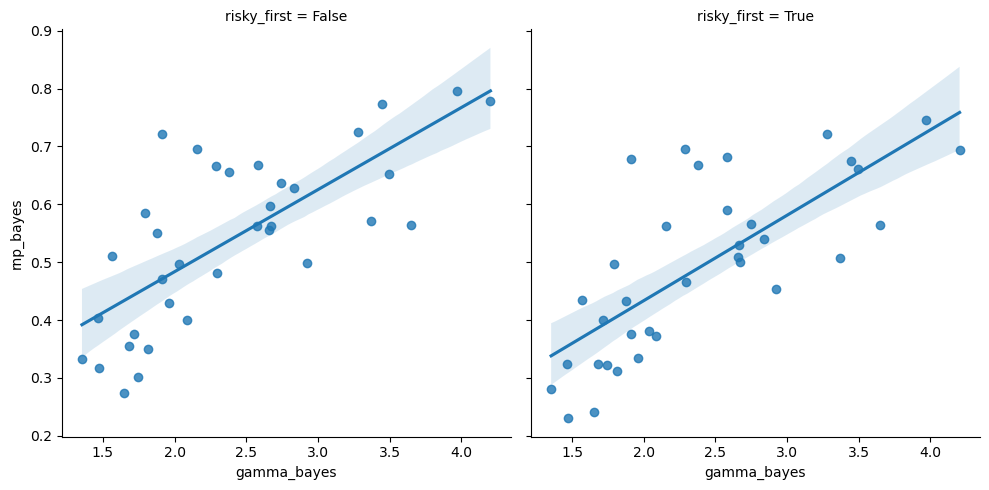

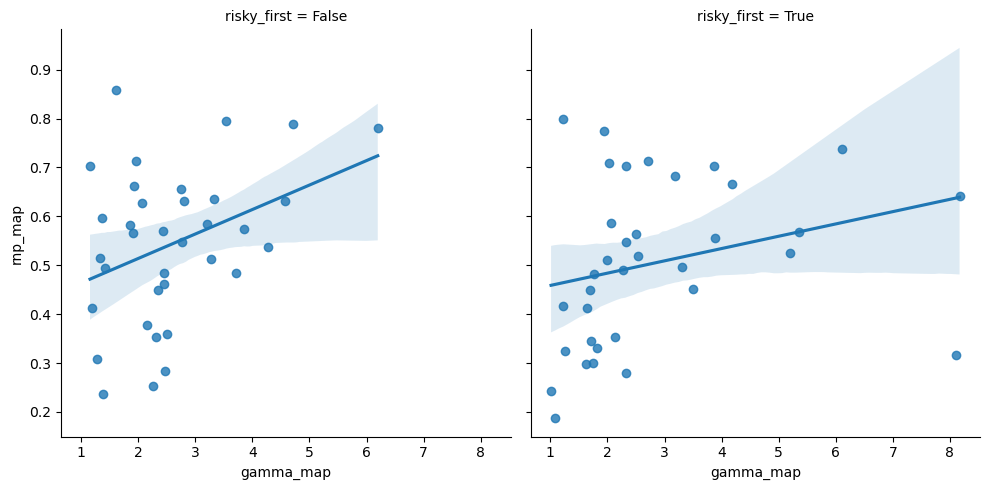

In [377]:
sns.lmplot(data=pars.groupby(['subject', 'risky_first']).mean().reset_index(), x='gamma_bayes', y='rnp_bayes', fit_reg=True, col='risky_first')
sns.lmplot(data=pars.groupby(['subject', 'risky_first']).mean().reset_index(), x='gamma_map', y='rnp_map', fit_reg=True, col='risky_first')

subjectwise_pars = pars.groupby(['subject', 'risky_first']).mean().reset_index()

display(subjectwise_pars.groupby('risky_first').apply(lambda x: pg.corr(x['gamma_bayes'], x['rnp_bayes'])))
display(subjectwise_pars.groupby('risky_first').apply(lambda x: pg.corr(x['gamma_map'], x['rnp_map'])))

,,n,r,CI95%,p-val,BF10,power
risky_first,,,,,,,
False,pearson,32,0.803392,"[0.63, 0.9]",3.111827e-08,4.858e+05,0.999977
True,pearson,34,0.715061,"[0.5, 0.85]",2.016728e-06,1.054e+04,0.999010


,,n,r,CI95%,p-val,BF10,power
risky_first,,,,,,,
False,pearson,35,0.150105,"[-0.19, 0.46]",0.389417,0.3,0.138920
True,pearson,35,0.502365,"[0.2, 0.72]",0.002103,19.7,0.885557


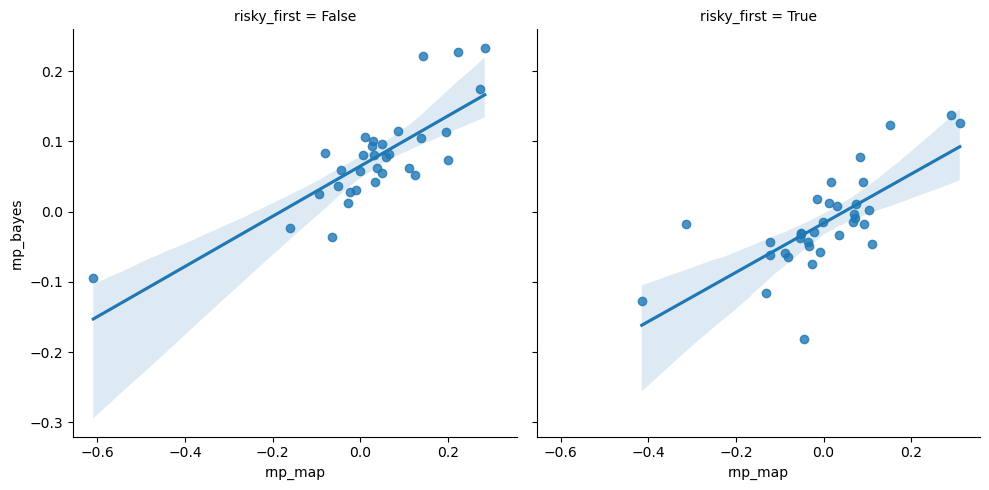

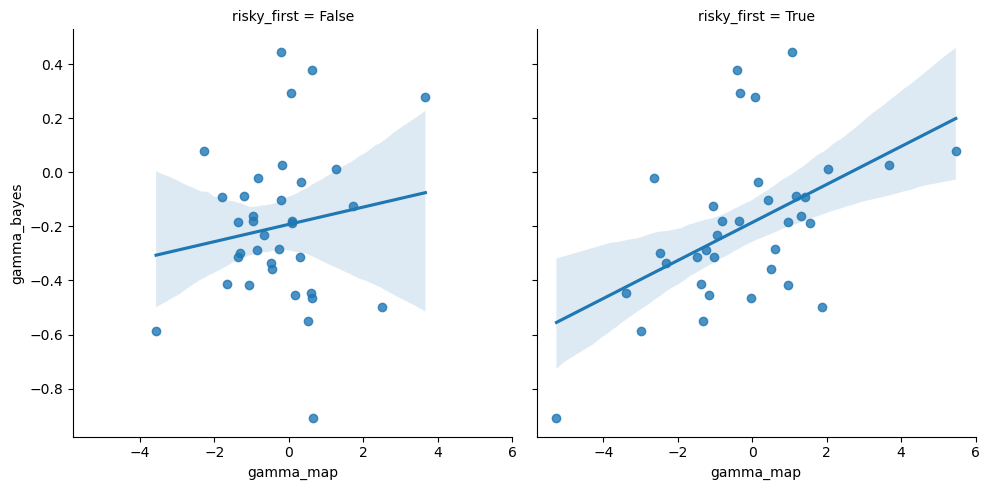

In [378]:
diff = pars.unstack('stimulation_condition').swaplevel(axis=1)

diff = diff['ips'] - diff['vertex']

sns.lmplot(data=diff.reset_index(), x='rnp_map', y='rnp_bayes', fit_reg=True, col='risky_first')
sns.lmplot(data=diff.reset_index(), x='gamma_map', y='gamma_bayes', fit_reg=True, col='risky_first')

display(diff.groupby('risky_first').apply(lambda x: pg.corr(x['rnp_map'], x['rnp_bayes'])))
display(diff.groupby('risky_first').apply(lambda x: pg.corr(x['gamma_map'], x['gamma_bayes'])))


,,n,r,CI95%,p-val,BF10,power
risky_first,,,,,,,
False,pearson,35,-0.328518,"[-0.6, 0.01]",0.054003,1.252,0.497444
True,pearson,35,-0.594447,"[-0.77, -0.33]",0.000166,189.276,0.974878


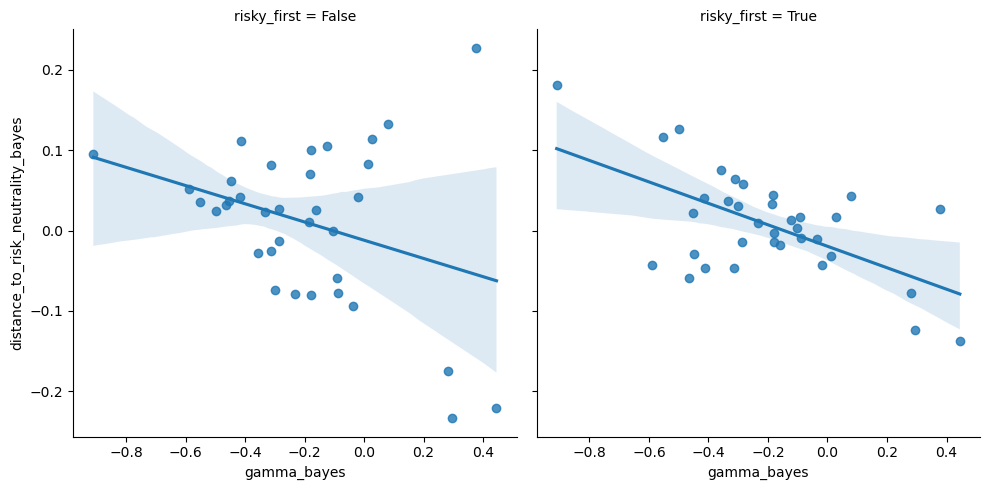

In [379]:
sns.lmplot(data=diff.reset_index(), x='gamma_bayes', y='distance_to_risk_neutrality_bayes', fit_reg=True, col='risky_first')

display(diff.groupby('risky_first').apply(lambda x: pg.corr(x['gamma_bayes'], x['distance_to_risk_neutrality_bayes'])))

/Users/gdehol/mambaforge/envs/tms_risk/lib/python3.11/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/gdehol/mambaforge/envs/tms_risk/lib/python3.11/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,risky_first,0.076706,1,30,0.076706,5.897070,0.021373,0.021373,0.019562,1.0
1,stimulation_condition,0.008163,1,30,0.008163,0.519658,0.476568,0.476568,0.002119,1.0
2,risky_first * stimulation_condition,0.008378,1,30,0.008378,1.211075,0.279872,0.279872,0.002175,1.0


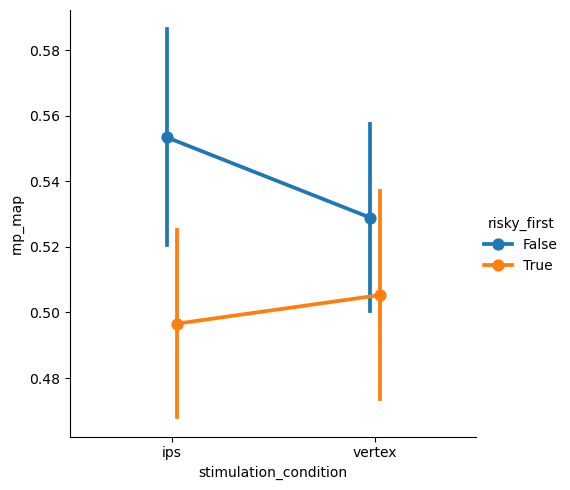

In [384]:
sns.catplot(x='stimulation_condition', y='rnp_map', data=pars.reset_index(), kind='point', hue='risky_first', errorbar='se', dodge=True)

pg.rm_anova(pars.reset_index(), dv='rnp_map', within=['risky_first', 'stimulation_condition'], subject='subject')

/Users/gdehol/mambaforge/envs/tms_risk/lib/python3.11/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/gdehol/mambaforge/envs/tms_risk/lib/python3.11/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,risky_first,2.347843,1,34,2.347843,0.712166,0.404624,0.404624,0.005669,1.0
1,stimulation_condition,1.783048,1,34,1.783048,1.211177,0.278830,0.278830,0.004311,1.0
2,risky_first * stimulation_condition,0.010123,1,34,0.010123,0.006849,0.934527,0.934527,0.000025,1.0


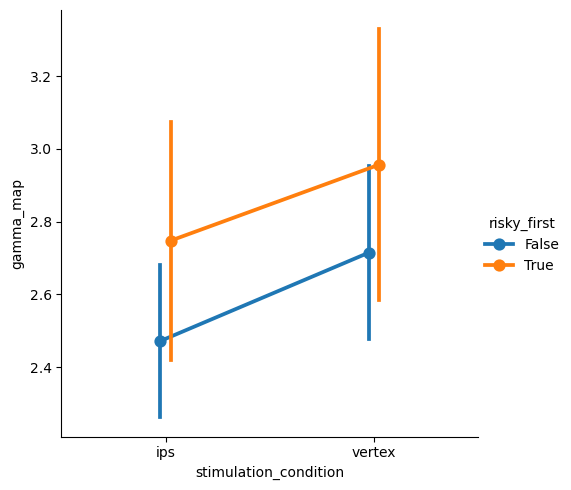

In [385]:
sns.catplot(x='stimulation_condition', y='gamma_map', data=pars.reset_index(), kind='point', hue='risky_first', errorbar='se', dodge=True)

pg.rm_anova(pars.reset_index(), dv='gamma_map', within=['risky_first', 'stimulation_condition'], subject='subject')

# Order model